<a href="https://colab.research.google.com/github/moodlep/mlc-proj-soccer/blob/main/Colabs/sb3_soccer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations

Copied from dm_control introduction tutorial

### Installing `dm_control` on Colab

This notebook provides an overview tutorial of DeepMind's `dm_control` package, hosted at the [deepmind/dm_control](https://github.com/deepmind/dm_control) repository on GitHub.

It is adjunct to this [tech report](http://arxiv.org/abs/2006.12983).

**A Colab runtime with GPU acceleration is required.** If you're using a CPU-only runtime, you can switch using the menu "Runtime > Change runtime type".

In [1]:
# Run to install MuJoCo and `dm_control`
import distutils.util
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

mujoco_dir = "$HOME/.mujoco"

print('Installing OpenGL dependencies...')
!apt-get update -qq
!apt-get install -qq -y --no-install-recommends libglew2.0 > /dev/null

print('Downloading MuJoCo...')
MUJOCO_VERSION = 210
MUJOCO_ARCHIVE = (
    f'mujoco{MUJOCO_VERSION}-{distutils.util.get_platform()}.tar.gz')
!wget -q "https://mujoco.org/download/{MUJOCO_ARCHIVE}"
!wget -q "https://mujoco.org/download/{MUJOCO_ARCHIVE}.sha256"
check_result = !shasum -c "{MUJOCO_ARCHIVE}.sha256"
if _exit_code:
  raise RuntimeError(
      'Downloaded MuJoCo archive is corrupted (checksum mismatch)')

print('Unpacking MuJoCo...')
MUJOCO_DIR = '$HOME/.mujoco'
!mkdir -p "{MUJOCO_DIR}"
!tar -zxf {MUJOCO_ARCHIVE} -C "{MUJOCO_DIR}"

# Configure dm_control to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl

print('Installing dm_control...')
!pip install -q dm_control

print('Checking that the dm_control installation succeeded...')
try:
  from dm_control import suite
  env = suite.load('cartpole', 'swingup')
  pixels = env.physics.render()
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')
else:
  del suite, env, pixels

Installing OpenGL dependencies...
Unpacking MuJoCo...
env: MUJOCO_GL=egl
Installing dm_control...
     |████████████████████████████████| 38.6 MB 1.3 MB/s 
     |████████████████████████████████| 205 kB 35.0 MB/s 
     |████████████████████████████████| 4.9 MB 6.9 MB/s 
Checking that the dm_control installation succeeded...


Exception ignored in: <function _create_finalizer.<locals>.callback at 0x7f14212bd710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/dm_control/mujoco/wrapper/core.py", line 261, in callback
  File "/usr/local/lib/python3.7/dist-packages/dm_control/mujoco/wrapper/core.py", line 802, in finalize_mjr_context
  File "/usr/lib/python3.7/contextlib.py", line 112, in __enter__
  File "/usr/local/lib/python3.7/dist-packages/dm_control/_render/base.py", line 114, in make_current
RuntimeError: Cannot make context <dm_control._render.pyopengl.egl_renderer.EGLContext object at 0x7f142129cbd0> current on thread <Thread(_colab_inspector_thread, started daemon 139724577376000)>: this context is already current on another thread <_MainThread(MainThread, started 139725229442944)>.


## Installing SB3

In [2]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization

Reading package lists... Done
Building dependency tree       
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-3).
freeglut3-dev set to manually installed.
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following additional packages will be installed:
  xserver-common
Recommended packages:
  xfonts-base
The following NEW packages will be installed:
  xvfb
The following packages will be upgraded:
  xserver-common
1 upgraded, 1 newly installed, 0 to remove and 84 not upgraded.
Need to get 811 kB of archives.
After this operation, 2,272 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 xserver-common all 2:1.19.6-1ubuntu4.10 [26.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 811 kB in 1s (743 kB/s)
(Reading database ... 155227 files and directories currently installed.)
Preparing to unpack .../xserver-comm

In [3]:
!pip install stable-baselines3[extra]

     |████████████████████████████████| 174 kB 5.1 MB/s 


# Imports

# Imports

dm_control imports

In [4]:
#@title All `dm_control` imports required for this tutorial

# The basic mujoco wrapper.
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# PyMJCF
from dm_control import mjcf

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example
from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

# Soccer
from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation

In [5]:
#@title Other imports and helper functions

# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

## Other imports

In [6]:
import gym
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [7]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

# Testing installations

## SB3

In [13]:
from stable_baselines3 import PPO

env = gym.make("CartPole-v1")

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    # env.render()
    if done:
      obs = env.reset()

env.close()

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22       |
|    ep_rew_mean     | 22       |
| time/              |          |
|    fps             | 532      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 27.9         |
|    ep_rew_mean          | 27.9         |
| time/                   |              |
|    fps                  | 414          |
|    iterations           | 2            |
|    time_elapsed         | 9            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0085292505 |
|    clip_fraction        | 0.0981       |
|    clip_range           | 0.2          |
|    e

Errors with display (rendering)

https://stackoverflow.com/questions/53472940/nameerror-name-base-is-not-defined-openai-gym


https://davidrpugh.github.io/stochastic-expatriate-descent/openai/binder/google-colab/2020/04/16/remote-rendering-gym-envs.html



## Testing dm_control (taken from tutorial)

### Multi-Agent Soccer

Building on Composer and Locomotion libraries, the Multi-agent soccer environments, introduced in [this paper](https://arxiv.org/abs/1902.07151), follow a consistent task structure of Walkers, Arena, and Task where instead of a single walker, we inject multiple walkers that can interact with each other physically in the same scene. The code snippet below shows how to instantiate a 2-vs-2 Multi-agent Soccer environment with the simple, 5 degree-of-freedom `BoxHead` walker type.

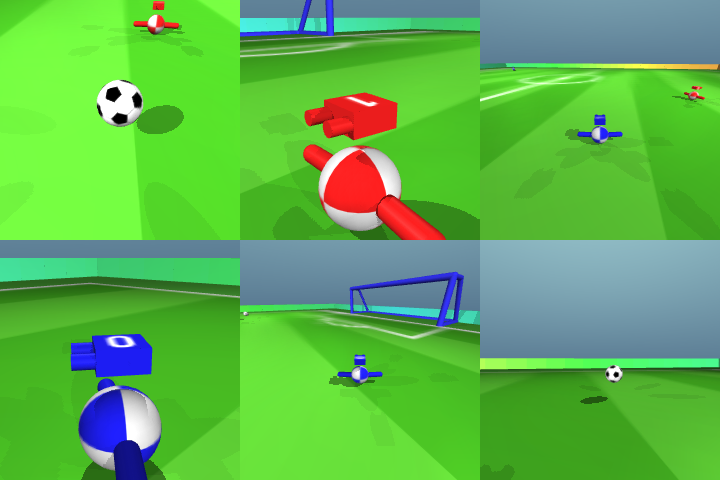

In [8]:
#@title 2-v-2 `Boxhead` soccer

random_state = np.random.RandomState(42)
env = soccer.load(
    team_size=2,
    time_limit=45.,
    random_state=random_state,
    disable_walker_contacts=False,
    walker_type=soccer.WalkerType.BOXHEAD,
)
env.reset()
pixels = []
# Select a random subset of 6 cameras (soccer envs have lots of cameras)
cameras = random_state.choice(env.physics.model.ncam, 6, replace=False)
for camera_id in cameras:
  pixels.append(env.physics.render(camera_id=camera_id, width=240))
image = np.vstack((np.hstack(pixels[:3]), np.hstack(pixels[3:])))
PIL.Image.fromarray(image)

In [9]:
state = env.reset()
state

TimeStep(step_type=<StepType.FIRST: 0>, reward=None, discount=None, observation=[OrderedDict([('body_height', array([1.])), ('end_effectors_pos', array([[0., 0., 0.]])), ('joints_pos', array([[0.]])), ('joints_vel', array([[0.]])), ('prev_action', array([[0., 0., 0.]])), ('sensors_accelerometer', array([[-1.44971364e-55,  2.51767267e-42,  0.00000000e+00]])), ('sensors_gyro', array([[-0.,  0.,  0.]])), ('sensors_velocimeter', array([[-0.,  0.,  0.]])), ('world_zaxis', array([[-0.,  0.,  1.]])), ('ball_ego_angular_velocity', array([[0., 0., 0.]])), ('ball_ego_position', array([[-4.59061861, 11.14147135, -0.15      ]])), ('ball_ego_linear_velocity', array([[0., 0., 0.]])), ('teammate_0_ego_linear_velocity', array([[0., 0., 0.]])), ('teammate_0_ego_position', array([[-28.45943793, -11.24506866,   0.        ]])), ('teammate_0_ego_orientation', array([[-0.99806643,  0.06215631,  0.        , -0.06215631, -0.99806643,
         0.        ,  0.        ,  0.        ,  1.        ]])), ('teammate_0

In [10]:
for i in env.observation_spec():
  print(i)

OrderedDict([('body_height', Array(shape=(1,), dtype=dtype('float64'), name='body_height')), ('end_effectors_pos', Array(shape=(1, 3), dtype=dtype('float64'), name='end_effectors_pos')), ('joints_pos', Array(shape=(1, 1), dtype=dtype('float64'), name='joints_pos')), ('joints_vel', Array(shape=(1, 1), dtype=dtype('float64'), name='joints_vel')), ('prev_action', Array(shape=(1, 3), dtype=dtype('float64'), name='prev_action')), ('sensors_accelerometer', Array(shape=(1, 3), dtype=dtype('float64'), name='sensors_accelerometer')), ('sensors_gyro', Array(shape=(1, 3), dtype=dtype('float64'), name='sensors_gyro')), ('sensors_velocimeter', Array(shape=(1, 3), dtype=dtype('float64'), name='sensors_velocimeter')), ('world_zaxis', Array(shape=(1, 3), dtype=dtype('float64'), name='world_zaxis')), ('ball_ego_angular_velocity', Array(shape=(1, 3), dtype=dtype('float64'), name='ball_ego_angular_velocity')), ('ball_ego_position', Array(shape=(1, 3), dtype=dtype('float64'), name='ball_ego_position')), (

In [11]:
env.action_spec()

[BoundedArray(shape=(3,), dtype=dtype('float64'), name='roll\tsteer\tkick', minimum=[-1. -1. -1.], maximum=[1. 1. 1.]),
 BoundedArray(shape=(3,), dtype=dtype('float64'), name='roll\tsteer\tkick', minimum=[-1. -1. -1.], maximum=[1. 1. 1.]),
 BoundedArray(shape=(3,), dtype=dtype('float64'), name='roll\tsteer\tkick', minimum=[-1. -1. -1.], maximum=[1. 1. 1.]),
 BoundedArray(shape=(3,), dtype=dtype('float64'), name='roll\tsteer\tkick', minimum=[-1. -1. -1.], maximum=[1. 1. 1.])]

In [12]:
env.action_spec()

[BoundedArray(shape=(3,), dtype=dtype('float64'), name='roll\tsteer\tkick', minimum=[-1. -1. -1.], maximum=[1. 1. 1.]),
 BoundedArray(shape=(3,), dtype=dtype('float64'), name='roll\tsteer\tkick', minimum=[-1. -1. -1.], maximum=[1. 1. 1.]),
 BoundedArray(shape=(3,), dtype=dtype('float64'), name='roll\tsteer\tkick', minimum=[-1. -1. -1.], maximum=[1. 1. 1.]),
 BoundedArray(shape=(3,), dtype=dtype('float64'), name='roll\tsteer\tkick', minimum=[-1. -1. -1.], maximum=[1. 1. 1.])]